# **Project Description:Twitter Nigerian 2023 Election Sentiment**

# **Data Description**:

- A sentiment analysis project on the opinion of twitter users about the Nigerian 2023 Election.
- This Twitter data consist of positive, negative, and neutral tweets given by Nigerians within and outside of the country based on how they feel about the Nigerian Presidential election.

# **Dataset**:

- The dataset was downloaded from the Twitter website.

# **Objective**:

- To classify the sentiment of tweets into the positive, neutral & negative.

# **Learning Outcomes**:
- Text based EDA
- Basic understanding of text pre-processing.
- What to do after text pre-processing:
    - Bag of words
    - Tf-idf
- Build the classification model.
- Tune & Evaluate the Model performance.
- Plot the  important features after training the model.

### Load the required packages

In [ ]:
# !pip install contractions
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# !pip install -Uq 'lightgbm>=3.3.1'
# !pip install transformers

In [ ]:
# import ligh gradient boosting model
import lightgbm as lgb

In [ ]:
# install and import necessary libraries.

# !pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.
from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# import ligh gradient boosting model
import lightgbm as lgb
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential #for adding layers
from tensorflow.keras.layers import Input, Dropout, TextVectorization, Dense, SimpleRNN, LSTM, Embedding #for different layers
from tensorflow.keras.layers import  SpatialDropout1D, Bidirectional

from tensorflow.keras.optimizers import Adam, SGD #import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #to save best performing model and help prevent overfiting
from tensorflow.keras.utils import to_categorical #to categorize each class of the target
from tensorflow.keras.preprocessing.text import Tokenizer #to tokenize the texts
from tensorflow.keras.preprocessing.sequence import pad_sequences #to enforce uniform length of data
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import torch
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Loading data into pandas dataframe
data1 = pd.read_csv("/content/drive/MyDrive/Files/Olaitan/data/raw/raw_labeled.csv",  encoding= 'unicode_escape')

In [ ]:
# Loading data into pandas dataframe
data2 = pd.read_csv("/content/drive/MyDrive/Files/Olaitan/data/raw/raw_labeled_full.csv",  encoding= 'unicode_escape')

In [ ]:
# show the first few rows of the data
data1.tail()

,Tweet,label
996,My aged uncle is in the village for s project....,Negative
997,TodayÃ¢ÂÂs HEADLINES!!! \n\nWhy We Postponed...,Positive
998,DON'T BE CONFUSED WE CAN ALWAYS MAKE IT HAPPEN...,Negative
999,"The chase is on, APC verses LPÃ°ÂÂÂ, Who wi...",Neutral
1000,The burnt Igbo's shops and destroy all their l...,Negative


In [ ]:
data1.shape

(1001, 2)

In [ ]:
data2 = data2.iloc[1002:, :]

data2.head()

,Tweet,label
1002,On colonny app you can share and get latest up...,Positive
1003,newsbulletinng : Court orders INEC to electron...,Neutral
1004,Court Grants INECâs Request To Reconfigure B...,Neutral
1005,Politics &amp; Governance \nWhat Festus Keyamo...,Neutral
1006,What Festus Keyamo Said On Appeal Courtâs Re...,Neutral


In [ ]:
# combine the two datasets together
df = pd.concat([data1, data2], ignore_index=True)

In [ ]:
# remove any rows with no review
df = df[~(df["Tweet"] == "")]

In [ ]:
# rename the sentiment column
# data.rename(columns = {"Analysis": "label"}, inplace=True)

In [ ]:
# sample some rows
df.sample(5)

,Tweet,label
4780,We can help you to raise fund for your dream p...,Neutral
6729,Final RESULTS Of the current PRESIDENTIAL ELEC...,Neutral
7134,INEC has just failed all Nigerians ð³ð¬ bl...,Negative
1381,"Please I need followers, I promise to follow b...",Neutral
8830,Protest loading...ðªðªð¡ï¸ð¡ï¸ð¡ï¸...,Negative


In [ ]:
# check the dimension of the data
df.shape                                               # print shape of data.

(9613, 2)

- The data has 9613 rows and 2 columns

### Data Exploration

In [ ]:
#df = data.copy()

In [ ]:
# check for missing rows
df.isnull().sum()

Tweet    0
label    0
dtype: int64

**Function to visualize the data**

In [ ]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#### Distribution of sentiments

In [ ]:
# categories of sentiments in the data
df["label"].value_counts().index

Index(['Neutral', 'Positive', 'Negative'], dtype='object')

- There are Positive, Negative, and Neutral sentiments in this data.

In [ ]:
#df.to_csv("./data/raw/raw_labeled.csv", index = False)

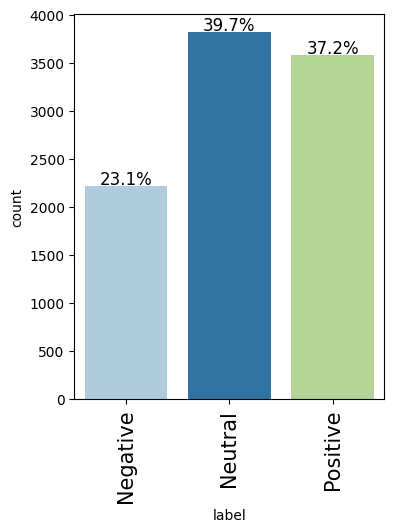

In [ ]:
labeled_barplot(df, "label", perc=True)

**39.7% of the tweets are labeled as Negutral, 37.2% are positive, and 23.1% are labeled Negative**.

In [ ]:
# distribution of the labels
df.label.value_counts()

Neutral     3815
Positive    3578
Negative    2220
Name: label, dtype: int64

- We have more neutral comment compared to the positive and negative comment about the election.

### **Visualizing the tweets before data cleaning**

In [ ]:
from wordcloud import WordCloud,STOPWORDS

In [ ]:
# Creating word cloud for negative reviews
def create_wordcloud(data, sent_value):
    reviews = data[data['label'] == sent_value]

    words = ' '.join(reviews['Tweet'])

    #cleaned_word = " ".join([word for word in words.split()])

    wordcloud = WordCloud(stopwords = STOPWORDS,
                      background_color = 'black',
                      width = 3000,
                      height = 2500
                     ).generate(words)

    plt.figure(1, figsize = (12, 12))

    plt.imshow(wordcloud)

    plt.axis('off')

    plt.show()

### **Wordcloud for positive reviews**

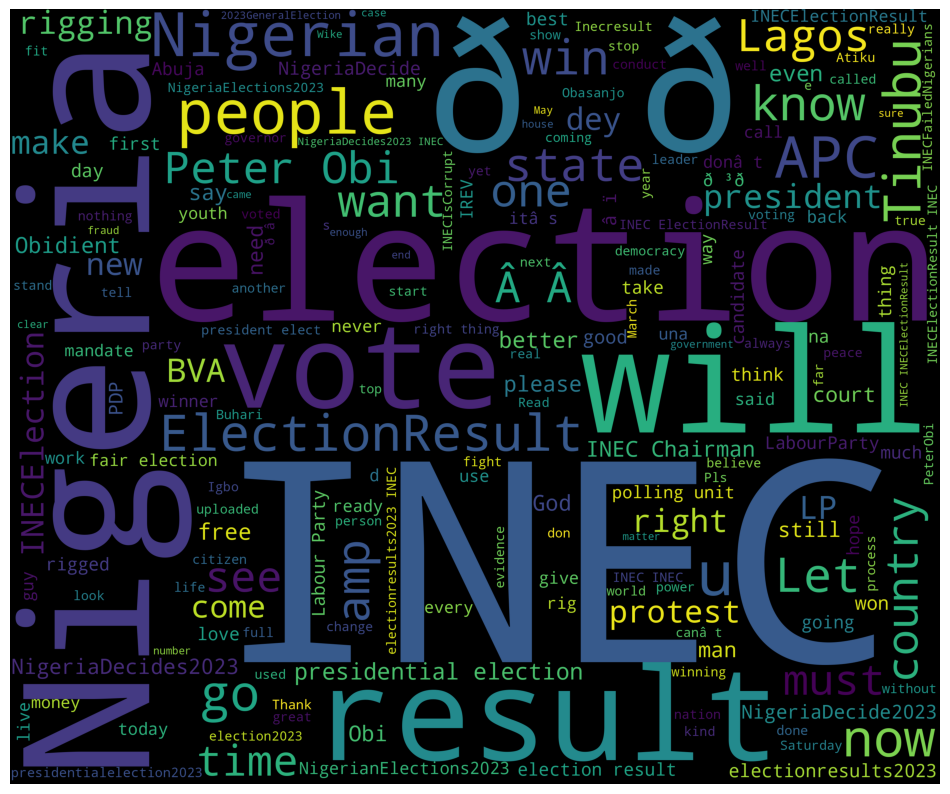

In [ ]:
# visualize the positive reviews before cleaning the data
create_wordcloud(df, "Positive")

#### **Wordcloud for negative reviews**

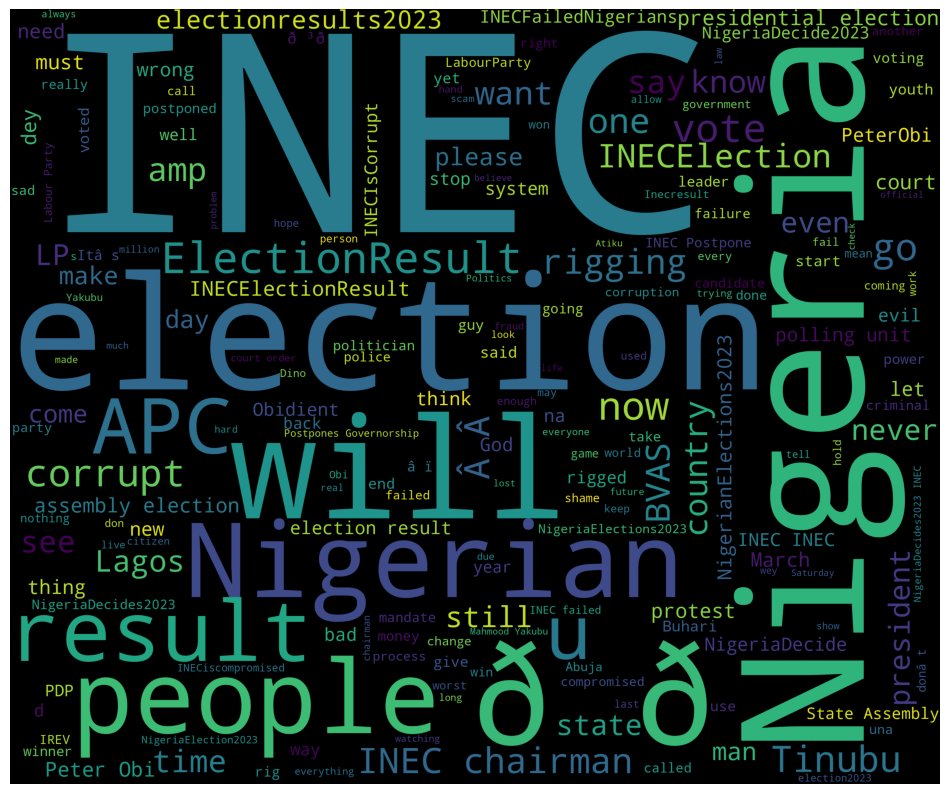

In [ ]:
# visualize the negative reviews before cleaning the data
create_wordcloud(df, "Negative")

- **Tweets with negative sentiment are frequently involved few words like corrupt, rigging, failure, and criminal.**

- **Tweets with positive sentiment are frequently involved few words like love, won, assures, and Thank.**

- In general, it is difficult to see clear words that indicate positive and negative reviews. Possible reasons would be because the data has not been cleaned.

### Data Pre-processing
Here, we will focus on cleaning the text data by performing the following tasks:

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.
- Remove numbers.
- Tokenization
- To remove Stopwords.
- Lemmatized data
- We have used NLTK library to tokenize words , remove stopwords and lemmatize the remaining words.

#### HTML Tags Removal
- Our goal here is to remove any form of HTML Tags that may be present in the tweets. Example of HTML tags include `<p>`, `<br>`

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df.loc[:,'Tweet'] = df['Tweet'].apply(lambda x: strip_html(x))

df.head()

,Tweet,label
0,WATCH HOW INEC AND APC RIGGED THE ELECTION AFT...,Negative
1,PROF SAHEED TO TINUBU. This is a BLAST,Negative
2,Trust me when I say we didn't just win but we ...,Positive
3,This new language is not a party revolutionary...,Negative
4,we didn't choose BAT. Nigerian decides 2023 el...,Negative


#### Fixing Contractions
- The goal here is to fix any form of contractionsin the tweet. Example of contractions include - isn't, doesn't, hasn't.

In [ ]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

df['Tweet'] = df['Tweet'].apply(lambda x: replace_contractions(x))
df.head()

,Tweet,label
0,WATCH HOW INEC AND APC RIGGED THE ELECTION AFT...,Negative
1,PROF SAHEED TO TINUBU. This is a BLAST,Negative
2,Trust me when I say we did not just win but we...,Positive
3,This new language is not a party revolutionary...,Negative
4,we did not choose BAT. Nigerian decides 2023 e...,Negative


#### Removing Digits
- Here, we will remove all digits in the tweet.

In [ ]:
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

df['Tweet'] = df['Tweet'].apply(lambda x: remove_numbers(x))
df.head()

,Tweet,label
0,WATCH HOW INEC AND APC RIGGED THE ELECTION AFT...,Negative
1,PROF SAHEED TO TINUBU. This is a BLAST,Negative
2,Trust me when I say we did not just win but we...,Positive
3,This new language is not a party revolutionary...,Negative
4,we did not choose BAT. Nigerian decides elect...,Negative


#### Tokenizing the text
- As tokenization is the basic unit required in every language modeling, we would be tokenizing each tweet into individual words.

In [ ]:
df['Tweet'] = df.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1) # Tokenization of data

In [ ]:
df.head()                                                                    # Look at how tokenized data looks.

,Tweet,label
0,"[WATCH, HOW, INEC, AND, APC, RIGGED, THE, ELEC...",Negative
1,"[PROF, SAHEED, TO, TINUBU, ., This, is, a, BLAST]",Negative
2,"[Trust, me, when, I, say, we, did, not, just, ...",Positive
3,"[This, new, language, is, not, a, party, revol...",Negative
4,"[we, did, not, choose, BAT, ., Nigerian, decid...",Negative


#### Removing Non-ASCII characters
- Here, we normalize and replace any special characters in the tweet with its normal alphabetic form.

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

df['Tweet'] = df['Tweet'].apply(lambda x: remove_non_ascii(x))
df.head()

,Tweet,label
0,"[WATCH, HOW, INEC, AND, APC, RIGGED, THE, ELEC...",Negative
1,"[PROF, SAHEED, TO, TINUBU, ., This, is, a, BLAST]",Negative
2,"[Trust, me, when, I, say, we, did, not, just, ...",Positive
3,"[This, new, language, is, not, a, party, revol...",Negative
4,"[we, did, not, choose, BAT, ., Nigerian, decid...",Negative


#### Lowercase the Text
- Here, we convert all tokens to their lowercase form to ensure consistency across the tweet.

In [ ]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

df['Tweet'] = df['Tweet'].apply(lambda x: to_lowercase(x))
df.head()

,Tweet,label
0,"[watch, how, inec, and, apc, rigged, the, elec...",Negative
1,"[prof, saheed, to, tinubu, ., this, is, a, blast]",Negative
2,"[trust, me, when, i, say, we, did, not, just, ...",Positive
3,"[this, new, language, is, not, a, party, revol...",Negative
4,"[we, did, not, choose, bat, ., nigerian, decid...",Negative


#### Removing Punctuation
- Here, we remove all punctuations represented as tokens in the tweet.

In [ ]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

df['Tweet'] = df['Tweet'].apply(lambda x: remove_punctuation(x))
df.head()

,Tweet,label
0,"[watch, how, inec, and, apc, rigged, the, elec...",Negative
1,"[prof, saheed, to, tinubu, this, is, a, blast]",Negative
2,"[trust, me, when, i, say, we, did, not, just, ...",Positive
3,"[this, new, language, is, not, a, party, revol...",Negative
4,"[we, did, not, choose, bat, nigerian, decides,...",Negative


#### Removing Stopwords
- Stopwords are commonly used words but adds little to no meaning when it comes to building machine learning models. Examples are `The`, `a`, pronouns such as `ourselves`, `he`
- Thus, we will remove all stopwords in the tweet.

In [ ]:
# create an instance of the English stopwords
stop_words = stopwords.words('english')

In [ ]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

df['Tweet'] = df['Tweet'].apply(lambda x: remove_stopwords(x))
df.head()

,Tweet,label
0,"[watch, inec, apc, rigged, election, apc, hack...",Negative
1,"[prof, saheed, tinubu, blast]",Negative
2,"[trust, say, win, huge, margin, check, followe...",Positive
3,"[new, language, party, revolutionary, movement...",Negative
4,"[choose, bat, nigerian, decides, election, res...",Negative


#### Remove Dominant Words
- It appears that the words "Inec", "Election", "Nigeria" and "Nigerian" appears a lot in the text as evident in the Word Cloud. So, we will exclude them from the tweet to avoid them from influencing the machine learning model.

In [ ]:
def remove_dominant_words(row):
  dominant_words = ["inec", "election",  "elections", "nigeria", "nigerian", "nigerians"]
  words = [word for word in row if word not in dominant_words]
  return words

df['Tweet'] = df['Tweet'].apply(lambda x: remove_dominant_words(x))
df.head()

,Tweet,label
0,"[watch, apc, rigged, apc, hackers, turn]",Negative
1,"[prof, saheed, tinubu, blast]",Negative
2,"[trust, say, win, huge, margin, check, followe...",Positive
3,"[new, language, party, revolutionary, movement...",Negative
4,"[choose, bat, decides, results]",Negative


#### Lemmatize the Text
- Lemmatization involves converting a word to its base or root form by maintaining an internal dictionary lookup. It always consider the semantic meaning and part of speech of each word being lemmatized.
- Here, we will lemmatize each word in the tweet.

In [ ]:
# create an instance of the lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatize_list(words):
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return " ".join(new_words)



In [ ]:
df["Tweet"] = df['Tweet'].apply(lambda x: lemmatize_list(x))
df.head()

,Tweet,label
0,watch apc rig apc hackers turn,Negative
1,prof saheed tinubu blast,Negative
2,trust say win huge margin check followers obed...,Positive
3,new language party revolutionary movement grea...,Negative
4,choose bat decide result,Negative


In [ ]:
# save the cleaned data
# path_to_save_data = "/content/drive/MyDrive/Files/Olaitan/data/clean_data/df_clean.csv"
# df.to_csv(path_to_save_data, index = False)

#### **Visualize the tweets after data cleaning**

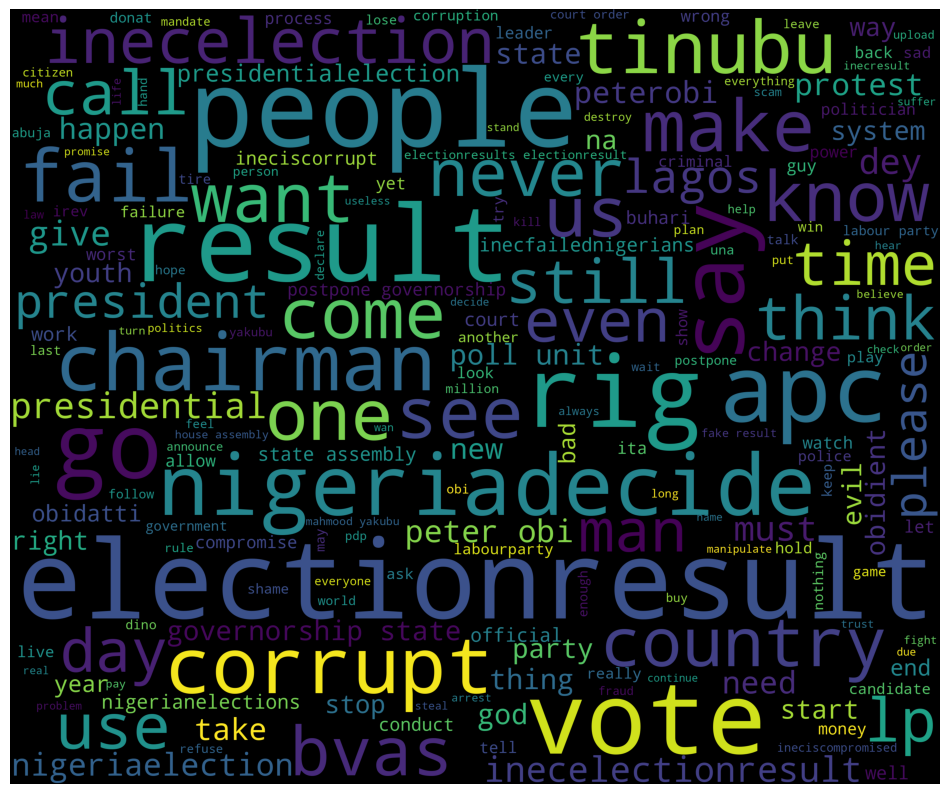

In [ ]:
create_wordcloud(df, "Negative")



- We cans see some negative words such as `fail`, `corrupt`, `evil`, `rig`, and `protest`

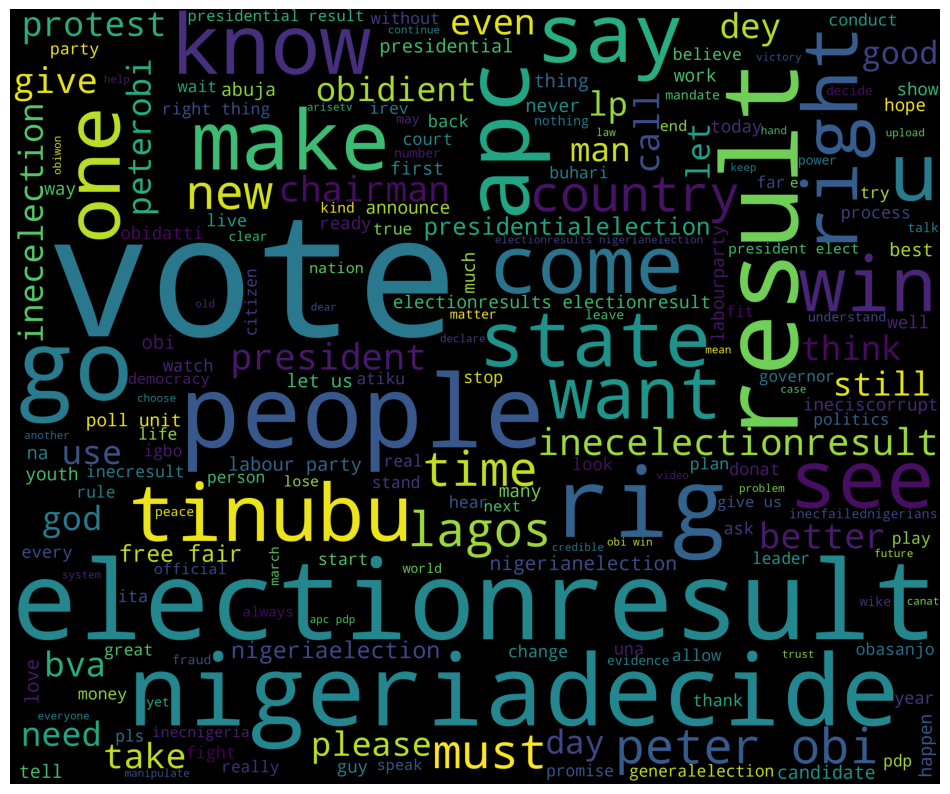

In [ ]:
# visualizing the positive tweet
create_wordcloud(df, "Positive")

- We can see the word `good`, `right`, and `win` in the positive tweet.

### Word Embeddings
- Word embedding refers to the process of converting the text into a numerical form. There are several word embedding methods. Here, we will consider the following:
  - Bag of Words (BOW): which involves representing each word by their frequencies in the tweet.
  - Term Frequency-Inverse Document Frequency (TF-IDF): which assigns weights to each word to denote their importance in the tweet.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# function to vectorize the reviews using both bag of words and tfidf
def review_vectorizer(data, review_column, BOW=True, TFIDF=True, max_feat=1000):
    """
    returns bow and tfidf vectors of the reviews
    df : dataframe
    review_column: specified column for the review
    max_feat: number of unique words or features to keep during vectorization
    """
    BW = CountVectorizer(max_features=max_feat)
    bow_vectors = BW.fit_transform(data[review_column]).toarray()

    TF = TfidfVectorizer(max_features=max_feat)
    tf_vectors = TF.fit_transform(data[review_column]).toarray()

    return bow_vectors, tf_vectors, BW, TF

### **Bag of Words Method**
- There are many unique words in this tweet which makes the size of our dictionary to be very large. Using all the words in our dictionary as the features would make training to be very slow. Hence, due to computational limitation, we would select the top 1000 features based on their frequencies.

In [ ]:
data_features_bow, data_features_tfidf, bw, tf = review_vectorizer(df, "Tweet")                     # Convert the data features to array.

In [ ]:
data_features_bow.shape    # dimension of the vectorized reviews

(9613, 1000)

In [ ]:
def createTrainTestData(data_features, target):
  X_large, X_test, y_large, y_test = train_test_split(data_features, target, test_size=0.15, random_state=0,stratify = target)

  X_train, X_val, y_train, y_val = train_test_split(X_large, y_large, test_size=0.15, random_state=0, stratify = y_large)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Split data into training, validation and testing set.
from sklearn.model_selection import train_test_split

X_train_bow, X_val_bow, X_test_bow, y_train_bow, y_val_bow, y_test_bow = createTrainTestData(data_features_bow, df.label)

In [ ]:
# check the size of the train, validation, and test datasets
print(f"There are {X_train_bow.shape[0]} rows in the train dataset")
print(f"There are {X_val_bow.shape[0]} rows in the validation dataset")
print(f"There are {X_test_bow.shape[0]} rows in the test dataset")

There are 6945 rows in the train dataset
There are 1226 rows in the validation dataset
There are 1442 rows in the test dataset


In [ ]:
def model_trainer(algorithm, X, y):
    """
    trains the model with given parameters
    algorithm: algorithm
    X: x_train scaled
    y = target
    """
    trained_model = algorithm.fit(X, y) #train the algorithm

    prediction = trained_model.predict(X)  #making prediction on the train data

    acc = accuracy_score(y, prediction)  #make predictions
    #print(f"train accuracy : {acc}")  #print accuracy
    print("train accuracy : {:.3f}".format(acc))
    return trained_model   #return trained model

def perf_evaluator(model, x_val, y_val):
    #make predicition
    y_pred = model.predict(x_val)
    #print classification report
    print(classification_report(y_val, y_pred))

    #obtain a confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True,  fmt = '.2f', xticklabels = ['negative', "neutral", 'positive'], yticklabels = ['negative', "neutral", 'positive'])

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()
    # confds = ConfusionMatrixDisplay(conf, display_labels=['positive', 'negative'])
    # confds.plot()

def train_and_evaluate(algo, x_train, y_train, x_val, y_val):
    """
    trains a model, test on the val set and returns the classification report
    """
    model = model_trainer(algo, x_train, y_train)
    performance = perf_evaluator(model, x_val, y_val)

    return model

### Building Models
- Here, we will consider some of the tree-based models to create baseline models, after which we will try to improve them using several approaches.

##### **Random Forest Model**

In [ ]:
# Function to print the classification report and get confusion matrix in a proper format
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

train accuracy : 0.994
              precision    recall  f1-score   support

    Negative       0.75      0.49      0.60       283
     Neutral       0.73      0.85      0.78       487
    Positive       0.74      0.76      0.75       456

    accuracy                           0.74      1226
   macro avg       0.74      0.70      0.71      1226
weighted avg       0.74      0.74      0.73      1226



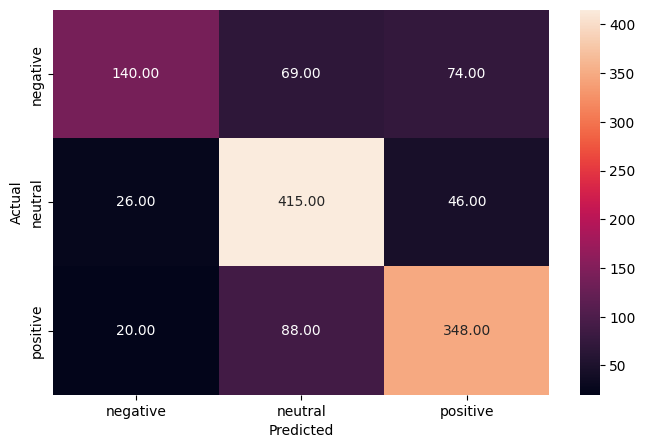

In [ ]:
# Using Random Forest to build model for the classification of tweets

rf = RandomForestClassifier(n_jobs=-1, random_state = 0)

rf_bow = train_and_evaluate(rf, X_train_bow, y_train_bow, X_val_bow, y_val_bow)  # train and evaluate a random forest model using bag of words method


- The training and evaluation performance shows that our random Forest overfit to the training data.

**The above results shows that our Random Forest Model is overfitting**

#### Visualize the top 40 words obtained in Bag of Words

In [ ]:
def get_top40_words(model, all_features):

    # Addition of top 40 feature into top_feature after training the model
    top_features=''

    feat = model.feature_importances_

    features = np.argsort(feat)[::-1]

    for i in features[0:40]:
        top_features+=all_features[i]
        top_features+=','

    from wordcloud import WordCloud

    wordcloud = WordCloud(background_color = "white", colormap = 'viridis', width = 2000,
                              height = 1000).generate(top_features)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.figure(1, figsize = (14, 11), frameon='equal')
    plt.title('Top 40 features WordCloud', fontsize = 10)
    plt.axis("off")
    plt.show()

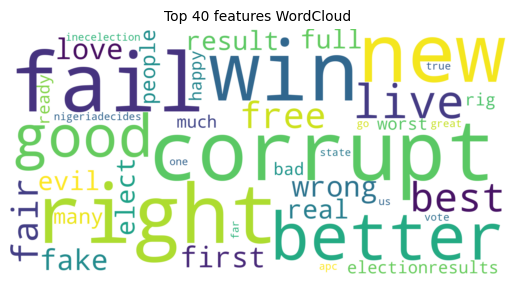

In [ ]:
features_bw = bw.get_feature_names_out()

get_top40_words(rf_bow,features_bw)

### Term Frequency - Inverse Document Frequency (TF-IDF)
- TF-IDF assigns weight to individual words in the text to indicate the importance of the words. Its intuition is that rare words better summarize a document than frequently occuring words.

In [ ]:
# split the TF-IDF features into train, validation, and test data
X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train_tfidf, y_val_tfidf, y_test_tfidf = createTrainTestData(data_features_tfidf, df.label)

train accuracy : 0.994
              precision    recall  f1-score   support

    Negative       0.77      0.40      0.53       283
     Neutral       0.71      0.89      0.79       487
    Positive       0.75      0.77      0.76       456

    accuracy                           0.73      1226
   macro avg       0.74      0.69      0.69      1226
weighted avg       0.74      0.73      0.72      1226



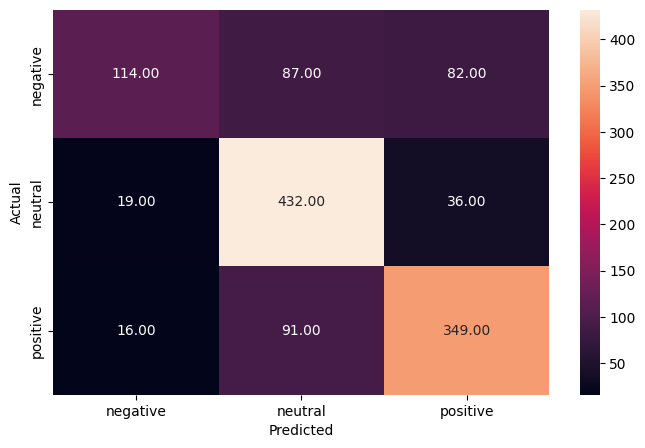

In [ ]:
rf_tfidf = train_and_evaluate(rf, X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)  # train and evaluate a random forest model using TF-IDF

- Clearly the Random Forest is overfitting also on the TF-IDF vectorized data

#### Visualize the top 40 words obtained in the TF-IDF

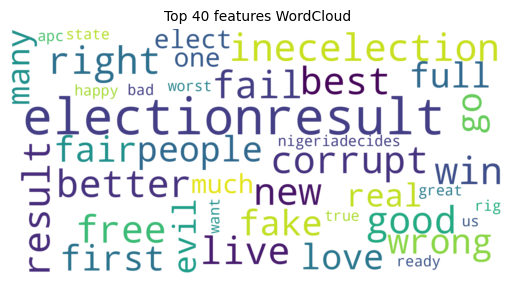

In [ ]:
features_tfidf = tf.get_feature_names_out()

get_top40_words(rf_tfidf,features_tfidf)

- Although our model overfits but it seems to learn some good features to distinguish the 3 classes of sentiments.

#### Light Gradient Boosting Model
- Here, we will implement the light gradient boosting models on both the BOW and the TF-IDF embeddings.

train accuracy : 0.733
              precision    recall  f1-score   support

    Negative       0.83      0.38      0.52       283
     Neutral       0.65      0.97      0.78       487
    Positive       0.84      0.70      0.76       456

    accuracy                           0.73      1226
   macro avg       0.77      0.68      0.69      1226
weighted avg       0.76      0.73      0.71      1226



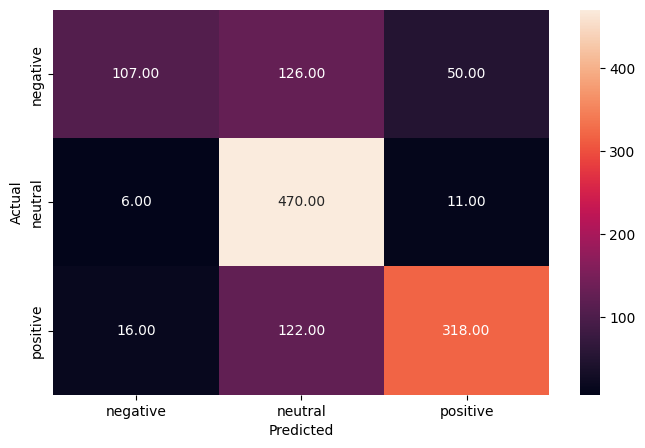

In [ ]:
lgb_bow = lgb.LGBMClassifier(max_depth=5, random_state = 0, verbose = -1)

lgb_bow = train_and_evaluate(lgb_bow, X_train_bow, y_train_bow, X_val_bow, y_val_bow)

train accuracy : 0.741
              precision    recall  f1-score   support

    Negative       0.86      0.36      0.50       283
     Neutral       0.65      0.97      0.78       487
    Positive       0.83      0.70      0.76       456

    accuracy                           0.73      1226
   macro avg       0.78      0.67      0.68      1226
weighted avg       0.76      0.73      0.71      1226



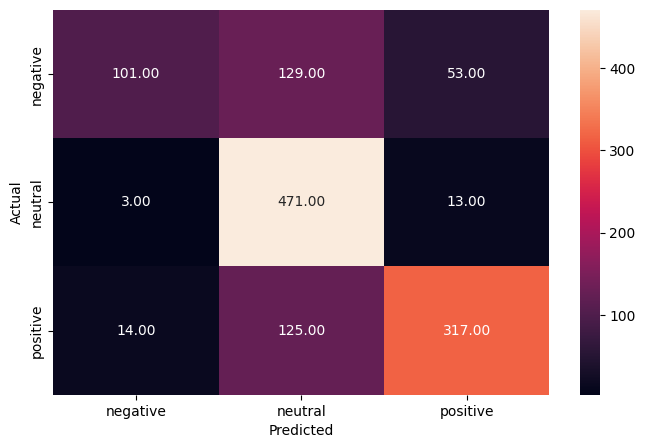

In [ ]:
lgb_tfidf = lgb.LGBMClassifier(max_depth=5, random_state = 0, verbose = -1)

lgb_tfidf = train_and_evaluate(gb, X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

- Light Gradient Bossting Model seem to generalize to our validation data.

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

train accuracy : 0.733
              precision    recall  f1-score   support

    Negative       0.85      0.39      0.53       283
     Neutral       0.64      0.97      0.77       487
    Positive       0.84      0.67      0.75       456

    accuracy                           0.72      1226
   macro avg       0.78      0.68      0.68      1226
weighted avg       0.76      0.72      0.71      1226



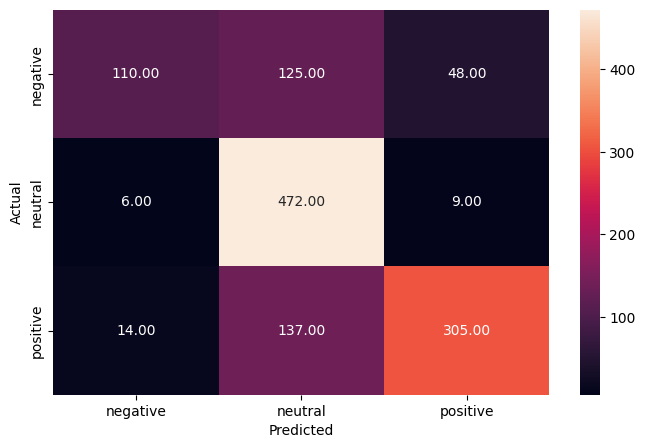

In [ ]:
gb_bow = GradientBoostingClassifier()

gb_bow = train_and_evaluate(gb_bow, X_train_bow, y_train_bow, X_val_bow, y_val_bow)

train accuracy : 0.739
              precision    recall  f1-score   support

    Negative       0.90      0.36      0.51       283
     Neutral       0.64      0.98      0.77       487
    Positive       0.83      0.67      0.74       456

    accuracy                           0.72      1226
   macro avg       0.79      0.67      0.67      1226
weighted avg       0.77      0.72      0.70      1226



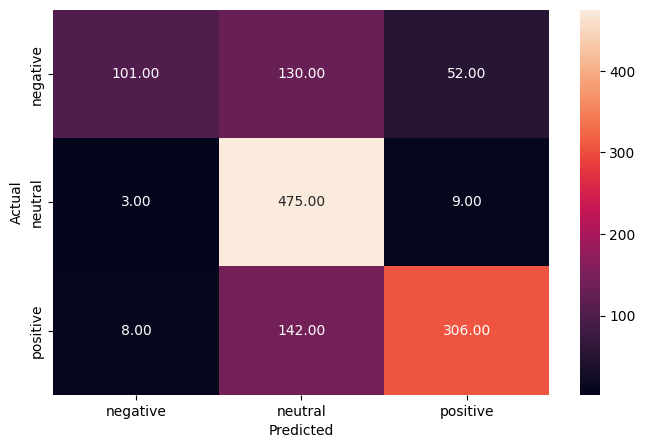

In [ ]:
gb_tfidf = GradientBoostingClassifier()

gb_tfidf = train_and_evaluate(gb_tfidf, X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf)

#### **Pre-trained Word Embeddings: Word2Vec**
- Our goal here is to train the random forest, gradient boosting, and light gradient boosting models on the Word2Vec embeddings.

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Get the list of all the sentences in the data

word_list = [sent.split() for sent in df["Tweet"]]

In [ ]:
# create the model
word2vec_model = Word2Vec(word_list, sg=1, vector_size=300)

In [ ]:
# create a vector representation of the text data using the Word2Vec model
def get_word_embeddings(model, words, vocab):
    embeddings = []
    for word in words:
        if word in vocab:
            embeddings.append(model.wv[word])
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(embeddings, axis=0)


def averaged_word_vectorizer(model, corpus):

    vocab = set(model.wv.key_to_index)

    features = [get_word_embeddings(model, tokenized_sentence, vocab)
                    for tokenized_sentence in corpus]

    return np.array(features)

In [ ]:
# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus = word_list, model = word2vec_model)

# select the features and the target
X = w2v_feature_array

y = df["label"]

In [ ]:
# split the word2vec features into train, validation, and test data
X_train_w2v, X_val_w2v, X_test_w2v, y_train_w2v, y_val_w2v, y_test_w2v = createTrainTestData(X, y)

#### Random Forest + Word2Vec

train accuracy : 0.998
              precision    recall  f1-score   support

    Negative       0.45      0.27      0.33       283
     Neutral       0.59      0.66      0.62       487
    Positive       0.53      0.61      0.57       456

    accuracy                           0.55      1226
   macro avg       0.53      0.51      0.51      1226
weighted avg       0.54      0.55      0.54      1226



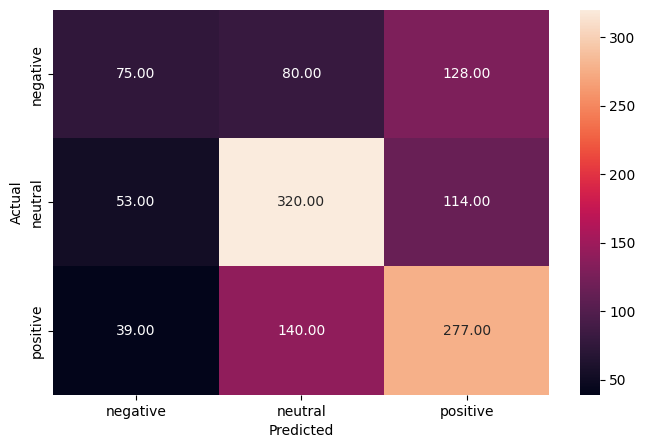

In [ ]:
rf_w2v = RandomForestClassifier(random_state = 0)

rf_w2v = train_and_evaluate(rf_w2v, X_train_w2v, y_train_w2v, X_val_w2v, y_val_w2v)

### Gradient Boosting + Word2Vec

train accuracy : 0.673
              precision    recall  f1-score   support

    Negative       0.48      0.25      0.33       283
     Neutral       0.60      0.68      0.64       487
    Positive       0.52      0.60      0.56       456

    accuracy                           0.55      1226
   macro avg       0.53      0.51      0.51      1226
weighted avg       0.54      0.55      0.54      1226



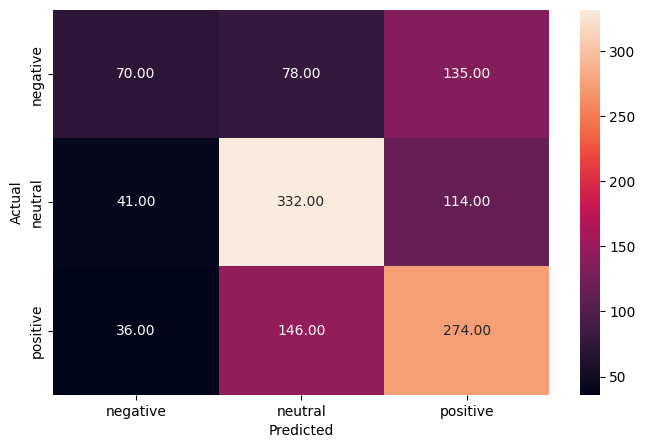

In [ ]:
gb_w2v = GradientBoostingClassifier(random_state = 0)

gb_w2v = train_and_evaluate(gb_w2v, X_train_w2v, y_train_w2v, X_val_w2v, y_val_w2v)

#### Light Gradient Boosting + Word2Vec

train accuracy : 0.877
              precision    recall  f1-score   support

    Negative       0.51      0.30      0.38       283
     Neutral       0.59      0.65      0.62       487
    Positive       0.53      0.61      0.57       456

    accuracy                           0.55      1226
   macro avg       0.55      0.52      0.52      1226
weighted avg       0.55      0.55      0.54      1226



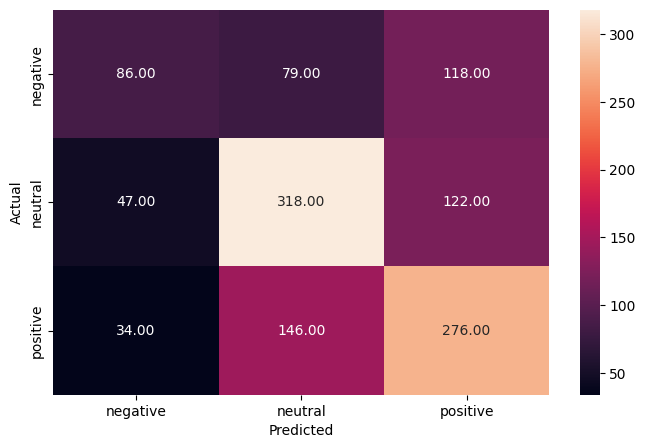

In [ ]:
lgb_w2v = lgb.LGBMClassifier(max_depth=5, random_state = 0, verbose = -1)
lgb_w2v = train_and_evaluate(lgb_w2v, X_train_w2v, y_train_w2v, X_val_w2v, y_val_w2v)

- Word2Vec embdeeings seem to perform poorly compared to the results from Bag of Words and TF-IDF

#### Global Vectors (GloVe) Embeddings

- GloVe is an alternative to Word2vec. Just like Word2vec, it is also an unsupervised learning algorithm that allows us to take a corpus of text, and intuitively map each word in that document into a position in a high-dimensional latent space which gives us the vector representation of the word.
- Our goal is to train the random forest, gradient boosting, and light gradient boosting model on the GloVe embeddings.

In [ ]:
# load the GloVe vectors in a dictionary:
emb_path = "/content/drive/MyDrive/Files/Data/GloVe/glove.42B.300d.txt"

def getGloVeEmbeddings(emb_path):
  embeddings_index = {}
  f = open(emb_path, encoding="utf8")

  for line in f:
      # Splitting the each line
      values = line.split()

      word = values[0]

      coefs = np.array(values[1:], dtype='float32')

      embeddings_index[word] = coefs

  f.close()

  print('Found %s word vectors.' % len(embeddings_index))
  return embeddings_index

In [ ]:
embeddings_index = getGloVeEmbeddings(emb_path)

Found 1917494 word vectors.


In [ ]:
# This function creates a normalized vector for the whole sentence

def sent2vec(s):
    words = word_tokenize(s)
    N = []
    for w in words:
        try:
            N.append(embeddings_index[w])
        except:
            continue
    N = np.array(N)
    v = N.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
# select the features and target
X = df["Tweet"].values
y = df["label"]

In [ ]:
# split the data
xtrain, xtest, ytrain, ytest = train_test_split(X, y, stratify = y, random_state = 42, test_size = 0.2, shuffle = True)

In [ ]:
# Create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in xtrain]
xtest_glove = [sent2vec(x) for x in xtest]

### Random Forest + GloVe

train accuracy : 0.998
              precision    recall  f1-score   support

    Negative       0.61      0.24      0.35       444
     Neutral       0.60      0.77      0.67       763
    Positive       0.58      0.63      0.61       716

    accuracy                           0.60      1923
   macro avg       0.60      0.55      0.54      1923
weighted avg       0.60      0.60      0.57      1923



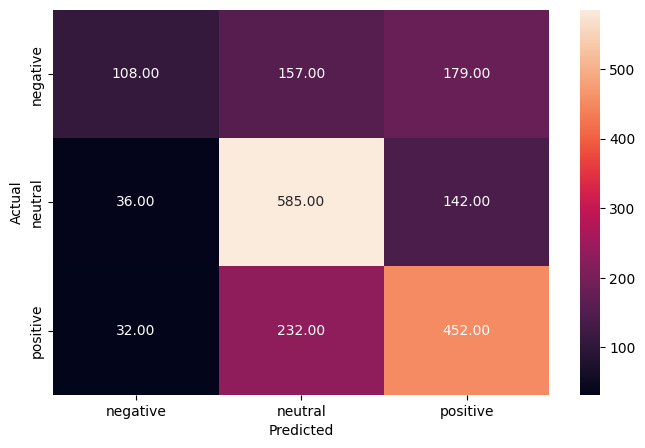

In [ ]:
rf_glove = RandomForestClassifier(random_state = 0)

rf_glove = train_and_evaluate(rf_glove, xtrain_glove, ytrain, xtest_glove, ytest)

#### Light GBM + GloVe

train accuracy : 0.965
              precision    recall  f1-score   support

    Negative       0.60      0.41      0.49       444
     Neutral       0.66      0.74      0.70       763
    Positive       0.61      0.66      0.64       716

    accuracy                           0.63      1923
   macro avg       0.63      0.60      0.61      1923
weighted avg       0.63      0.63      0.63      1923



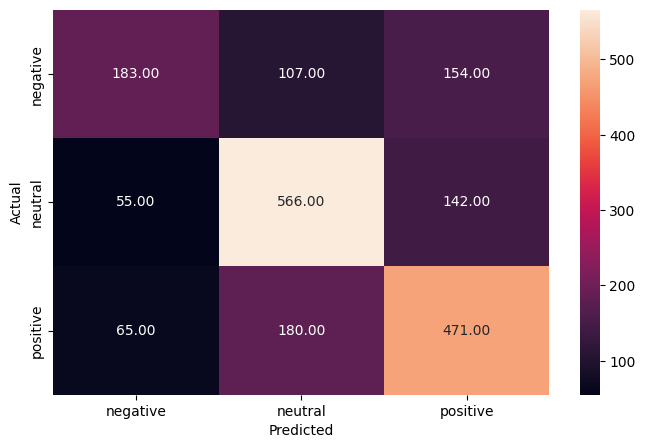

In [ ]:
lgb_glove = lgb.LGBMClassifier(max_depth=5, random_state = 0, verbose = -1)
lgb_glove = train_and_evaluate(lgb_glove, xtrain_glove, ytrain, xtest_glove, ytest)

### Gradient Boosting + GloVe

train accuracy : 0.757
              precision    recall  f1-score   support

    Negative       0.59      0.37      0.46       444
     Neutral       0.64      0.71      0.67       763
    Positive       0.60      0.67      0.63       716

    accuracy                           0.62      1923
   macro avg       0.61      0.58      0.59      1923
weighted avg       0.61      0.62      0.61      1923



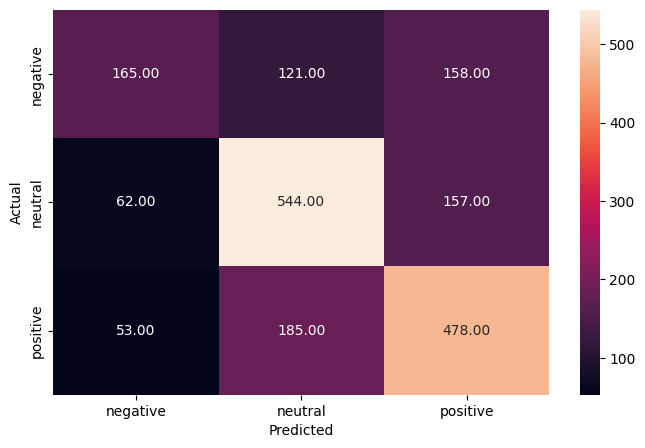

In [ ]:
gb_glove = GradientBoostingClassifier()
gb_glove = train_and_evaluate(gb_glove, xtrain_glove, ytrain, xtest_glove, ytest)

- The Glove Model seems to perform better than the Word2Vec but in general it also overfits.

### Implementing Recurrent Neural Networks
- Here, I would consider basic RNN and LSTM neural networks since we are dealing with a sequential data.

##### RNN
- SimpleRNN is a type of recurrent neural network that is designed to process sequential data.
- It is the simplest form of RNN and has a single layer of recurrent units.
- Each unit takes an input along with the output from the previous time step, and it produces an output that is passed to the next time step.
- SimpleRNN has limitations in capturing long-range dependencies in sequences, often suffering from the vanishing gradient problem, where gradients can become very small, making it difficult to learn dependencies over long time lags.

In [ ]:
#initialize the tokenizer
tokenizer = Tokenizer(num_words=1000)

#fit on data to update vocabulary
tokenizer.fit_on_texts(df['Tweet'].values)

#convert text to sequence of integers
X_ve = tokenizer.texts_to_sequences(df['Tweet'].values)

##### Pad the sequence
- In order to reduce the problem of sparisity and rather than using maximum length of comment as the max length, I will obtain the descriptive stats of the length of all the comments as this will help me know the best padding length to use.

In [ ]:
def countString(tweet):
  # split the tweet
  tokens = tweet.split()
  tokenLen = len(tokens)
  return tokenLen

df["TweetLength"] = df["Tweet"].apply(lambda x: countString(x))

In [ ]:
df["TweetLength"].describe()

count    9613.000000
mean       13.292625
std         7.053890
min         0.000000
25%         8.000000
50%        13.000000
75%        19.000000
max        39.000000
Name: TweetLength, dtype: float64

- The statistics shows that 75% of the texts contains no more than 19 words as the longest tweet contains 39 words. Thus, I would use a maximum length of 20.

In [ ]:
# To ensure consistency in length
X = pad_sequences(X_ve, maxlen=20)
y = df['label']


In [ ]:
# Split the data into train,validation, and test data
x_large, x_test, y_large, y_test = train_test_split(X, y, random_state=0,stratify=y,
                                                   test_size=0.15)
x_train, x_val, y_train, y_val = train_test_split(x_large, y_large, random_state=0,stratify=y_large,
                                                   test_size=0.15)

In [ ]:
x_train.shape

(6945, 20)

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# define early stopping layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
est = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

#define modelcheckpoint to save best model
rnn_path = '/content/drive/MyDrive/Files/Olaitan/Models/rnnModel.hdf5'
mcp = ModelCheckpoint(filepath = rnn_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose = 1)

In [ ]:
def RNN_model(embedding_dims=100,output_sequence_length=100, hidden_dims=128):
    model = Sequential()



    model.add(Embedding(1000, output_dim=embedding_dims,input_length=X.shape[1]))

    model.add(SimpleRNN(units=hidden_dims, recurrent_dropout=0.2, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(SimpleRNN(units=hidden_dims, recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation ='softmax'))
    model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

    return model

In [ ]:
# Apply the function
rnn_model = RNN_model()
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           100000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 128)           29312     
                                                                 
 dropout_2 (Dropout)         (None, 20, 128)           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 162,595
Trainable params: 162,595
Non-tr

In [ ]:
x_train

array([[  0,   0,   0, ...,   2,   7, 525],
       [  0,   0,   0, ..., 336,   7,  16],
       [  0,   0,   0, ..., 941,  52,  25],
       ...,
       [  0,   0,   0, ...,   0,   0, 490],
       [  0,   0,   0, ...,   0,   1, 123],
       [  0,   0,   0, ..., 327,  12,  68]], dtype=int32)

In [ ]:
# create an instance of the Label Encoder
enc = LabelEncoder()

# convert to sentiments to integers where 0: Negative, 1: Neutral, 2: Positive
y_train_enc = enc.fit_transform(y_train)
y_val_enc = enc.fit_transform(y_val)
y_test_enc = enc.fit_transform(y_test)

# convert to OneHot Encoded labels
y_train_c = to_categorical(y_train_enc)
y_val_c = to_categorical(y_val_enc)
y_test_c = to_categorical(y_test_enc)

In [ ]:
rnn1_history = rnn_model.fit(x_train, y_train_c, batch_size=32,
        validation_data= (x_val, y_val_c), epochs=30, callbacks=[est, mcp], verbose = 1)

Epoch 1/30
216/218 [============================>.] - ETA: 0s - loss: 1.1718 - accuracy: 0.4120
Epoch 1: val_accuracy improved from -inf to 0.47471, saving model to /content/drive/MyDrive/Files/Olaitan/Models/rnnModel.hdf5
218/218 [==============================] - 12s 38ms/step - loss: 1.1714 - accuracy: 0.4121 - val_loss: 1.1568 - val_accuracy: 0.4747
Epoch 2/30
217/218 [============================>.] - ETA: 0s - loss: 1.0037 - accuracy: 0.5258
Epoch 2: val_accuracy improved from 0.47471 to 0.58401, saving model to /content/drive/MyDrive/Files/Olaitan/Models/rnnModel.hdf5
218/218 [==============================] - 10s 44ms/step - loss: 1.0036 - accuracy: 0.5258 - val_loss: 1.0335 - val_accuracy: 0.5840
Epoch 3/30
217/218 [============================>.] - ETA: 0s - loss: 0.8700 - accuracy: 0.6286
Epoch 3: val_accuracy improved from 0.58401 to 0.63785, saving model to /content/drive/MyDrive/Files/Olaitan/Models/rnnModel.hdf5
218/218 [==============================] - 10s 47ms/step - 

In [ ]:
def view_performance(history):
  """
  plots the accuracy, val_accuracy and recall_score against epochs
  """
  #define accuracy
  acc = history.history['accuracy']

  #define validation_accuracy
  val_acc = history.history['val_accuracy']

  #specify epochs
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize= (5,5)) #set figure size
  plt.plot(epochs, acc, label="Train Accuracy") #plot accuracy against epochs
  plt.plot(epochs, val_acc, label="validation accuracy") #plot val_acc against epcohs
  #plt.plot(epochs, recall_vals, label="recall values")#plot recall values against epochs

  plt.legend(loc='best') #display the legends at the best location in the chart

  plt.show()#show the plot

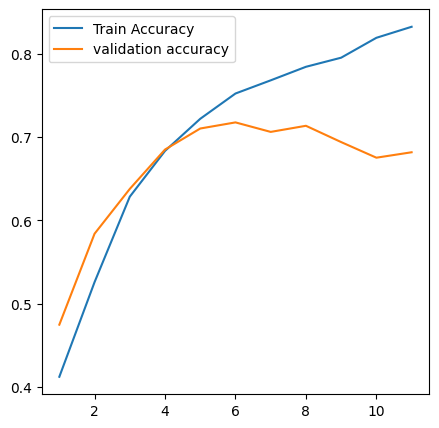

In [ ]:
view_performance(rnn1_history)

- Clearly, this model is overfitting and I would apply some techniques to reduce this overfitting problem.

#### Improving RNN Model
- Here, I would apply a dropout layer to reduce the rate of overfitting.

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
def RNN_model2(embedding_dims=100,output_sequence_length=100, hidden_dims=128):
    model = Sequential()



    model.add(Embedding(1000, output_dim=embedding_dims,input_length=X.shape[1]))

    model.add(SimpleRNN(units=hidden_dims, recurrent_dropout=0.2, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(SimpleRNN(units=hidden_dims, recurrent_dropout=0.2, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(SimpleRNN(units=hidden_dims, recurrent_dropout=0.6))
    model.add(Dropout(0.7))
    model.add(Dense(3, activation ='softmax'))
    model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

    return model

In [ ]:
# Apply the function
rnn_model2 = RNN_model2()
rnn_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 128)           29312     
                                                                 
 dropout (Dropout)           (None, 20, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 128)           32896     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [ ]:
#define modelcheckpoint to save best model
rnn_path2 = '/content/drive/MyDrive/Files/Olaitan/Models/rnnModel2.hdf5'
mcp2 = ModelCheckpoint(filepath = rnn_path2, save_best_only=True, monitor='val_loss', mode='min', verbose = 1)

In [ ]:
# rnn_model2 = Sequential()
# rnn_model2.add(Embedding(1000, output_dim=100,input_length=X.shape[1]))
# rnn_model2.add(SimpleRNN(units=32))
# rnn_model2.add(Dropout(0.5))
# rnn_model2.add(Dense(3, activation ='softmax'))
# rnn_model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

rnn2_history = rnn_model2.fit(x_train, y_train_c, batch_size=32,
        validation_data= (x_val, y_val_c), epochs=30, callbacks=[est, mcp2], verbose = 1)

Epoch 1/30
217/218 [============================>.] - ETA: 0s - loss: 1.5431 - accuracy: 0.3400
Epoch 1: val_loss improved from inf to 1.08910, saving model to /content/drive/MyDrive/Files/Olaitan/Models/rnnModel2.hdf5
218/218 [==============================] - 17s 63ms/step - loss: 1.5432 - accuracy: 0.3400 - val_loss: 1.0891 - val_accuracy: 0.3972
Epoch 2/30
217/218 [============================>.] - ETA: 0s - loss: 1.2158 - accuracy: 0.3720
Epoch 2: val_loss improved from 1.08910 to 1.07753, saving model to /content/drive/MyDrive/Files/Olaitan/Models/rnnModel2.hdf5
218/218 [==============================] - 13s 59ms/step - loss: 1.2157 - accuracy: 0.3721 - val_loss: 1.0775 - val_accuracy: 0.3989
Epoch 3/30
217/218 [============================>.] - ETA: 0s - loss: 1.1182 - accuracy: 0.3751
Epoch 3: val_loss improved from 1.07753 to 1.07510, saving model to /content/drive/MyDrive/Files/Olaitan/Models/rnnModel2.hdf5
218/218 [==============================] - 15s 71ms/step - loss: 1.11

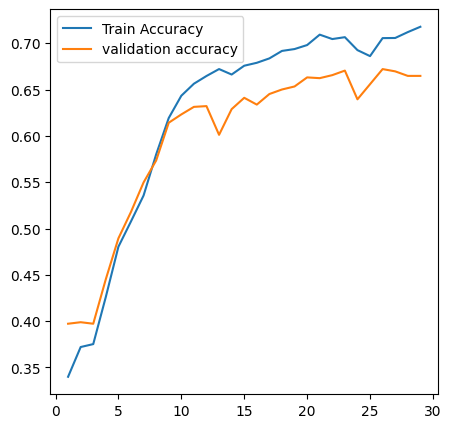

In [ ]:
view_performance(rnn2_history)

- Adding a dropout layer did not improve the performance of the model.

### LSTM
- LSTM is an advanced variant of the SimpleRNN that overcomes the limitations of the vanishing gradient problem.
- It introduces a more complex structure, including three gating mechanisms (input gate, output gate, and forget gate), that allow it to selectively update and forget information in its hidden state.
- The presence of these gates enables LSTM to retain information for long periods, making it well-suited for processing and learning from long sequences.
- The key advantage of LSTM over SimpleRNN is its ability to capture long-range dependencies and remember information over extended periods. - This makes LSTM more effective in tasks that involve long sequences, such as language modeling, machine translation, and sentiment analysis, among others.

**Bidirectional LSTM**:
The advantage of Bidirectional LSTM is that it can capture information from both past and future contexts of each word or element in the sequence. This enables the model to have a more comprehensive understanding of the sequential data.

In [ ]:
#define modelcheckpoint to save best model
lstm_path = '/content/drive/MyDrive/Files/Olaitan/Models/lstmModel.hdf5'
mcp3 = ModelCheckpoint(filepath = lstm_path, save_best_only=True, monitor='val_loss', mode='min', verbose = 1)

In [ ]:
embedding_dim = 100  # Dimension of the word embeddings
rnn_units = 32      # Number of RNN units
num_classes = 3      # Number of output classes (positive and negative)

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=1000, output_dim=embedding_dim, input_length=X.shape[1]))
lstm_model.add(SpatialDropout1D(0.3))
lstm_model.add(SimpleRNN(rnn_units, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
lstm_model.add(Bidirectional(LSTM(rnn_units, dropout=0.3, recurrent_dropout=0.3)))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(x_train, y_train_c, batch_size=32,
        validation_data= (x_val, y_val_c), epochs=30, callbacks=[est, mcp3], verbose = 1)

Epoch 1/30
217/218 [============================>.] - ETA: 0s - loss: 1.0437 - accuracy: 0.4673
Epoch 1: val_loss improved from inf to 0.98527, saving model to /content/drive/MyDrive/Files/Olaitan/Models/lstmModel.hdf5
218/218 [==============================] - 30s 92ms/step - loss: 1.0437 - accuracy: 0.4674 - val_loss: 0.9853 - val_accuracy: 0.5416
Epoch 2/30
218/218 [==============================] - ETA: 0s - loss: 0.9388 - accuracy: 0.5778
Epoch 2: val_loss improved from 0.98527 to 0.87042, saving model to /content/drive/MyDrive/Files/Olaitan/Models/lstmModel.hdf5
218/218 [==============================] - 21s 98ms/step - loss: 0.9388 - accuracy: 0.5778 - val_loss: 0.8704 - val_accuracy: 0.6199
Epoch 3/30
217/218 [============================>.] - ETA: 0s - loss: 0.8337 - accuracy: 0.6489
Epoch 3: val_loss improved from 0.87042 to 0.79432, saving model to /content/drive/MyDrive/Files/Olaitan/Models/lstmModel.hdf5
218/218 [==============================] - 23s 104ms/step - loss: 0.8

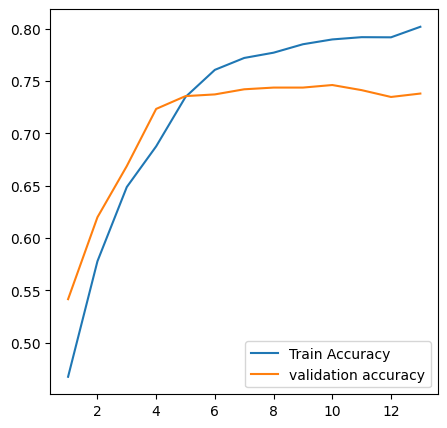

In [ ]:
view_performance(lstm_history)

### Improving the LSTM Model

In [ ]:
#define modelcheckpoint to save best model
lstm_path2 = '/content/drive/MyDrive/Files/Olaitan/Models/lstmModel.hdf5'
mcp4 = ModelCheckpoint(filepath = lstm_path2, save_best_only=True, monitor='val_loss', mode='min', verbose = 1)

In [ ]:
embedding_dim = 100  # Dimension of the word embeddings
rnn_units = 32      # Number of RNN units
num_classes = 3      # Number of output classes (positive and negative)

lstm_model2 = Sequential()
lstm_model2.add(Embedding(input_dim=1000, output_dim=embedding_dim, input_length=X.shape[1]))
lstm_model2.add(SpatialDropout1D(0.4))
lstm_model2.add(SimpleRNN(rnn_units, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
lstm_model2.add(Bidirectional(LSTM(rnn_units, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
lstm_model2.add(Dense(64, activation='relu'))
lstm_model2.add(Dropout(0.5))
lstm_model2.add(Bidirectional(LSTM(rnn_units, dropout=0.7, recurrent_dropout=0.5)))
lstm_model2.add(Dense(32, activation='relu'))
lstm_model2.add(Dropout(0.5))
lstm_model2.add(Dense(num_classes, activation='softmax'))

# Compile the model
lstm_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
lstm_history2 = lstm_model2.fit(x_train, y_train_c, batch_size=32,
        validation_data= (x_val, y_val_c), epochs=30, callbacks=[est, mcp4], verbose = 1)

Epoch 1/30
218/218 [==============================] - ETA: 0s - loss: 1.0789 - accuracy: 0.4014
Epoch 1: val_loss improved from inf to 1.05494, saving model to /content/drive/MyDrive/Files/Olaitan/Models/lstmModel.hdf5
218/218 [==============================] - 63s 173ms/step - loss: 1.0789 - accuracy: 0.4014 - val_loss: 1.0549 - val_accuracy: 0.4405
Epoch 2/30
218/218 [==============================] - ETA: 0s - loss: 1.0512 - accuracy: 0.4698
Epoch 2: val_loss improved from 1.05494 to 0.98489, saving model to /content/drive/MyDrive/Files/Olaitan/Models/lstmModel.hdf5
218/218 [==============================] - 31s 142ms/step - loss: 1.0512 - accuracy: 0.4698 - val_loss: 0.9849 - val_accuracy: 0.5408
Epoch 3/30
218/218 [==============================] - ETA: 0s - loss: 0.9925 - accuracy: 0.5434
Epoch 3: val_loss improved from 0.98489 to 0.93533, saving model to /content/drive/MyDrive/Files/Olaitan/Models/lstmModel.hdf5
218/218 [==============================] - 36s 165ms/step - loss: 0

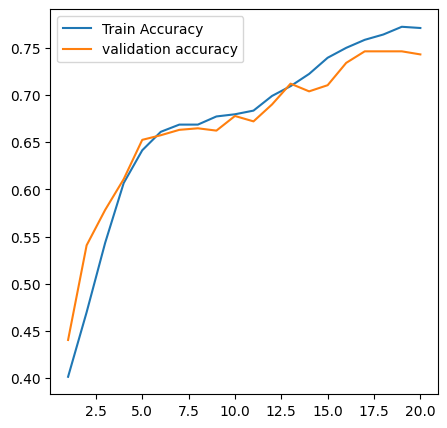

In [ ]:
view_performance(lstm_history2)

- The LSTM model seems to give the best model and it's also generalizable up to 4 epochs.

### Bidirectional Encoder Representation from Transformer (BERT)
- BERT is a type of transformer-based architecture that has achieved state-of-the-art performance in a wide range of NLP tasks, including sentiment analysis.
- BERT's key innovation lies in its bidirectional context understanding. Unlike traditional language models that process text sequentially (left-to-right or right-to-left), BERT reads the entire input sentence in both directions simultaneously. This allows it to capture the contextual meaning of words more accurately and handle complex linguistic structures.

#### Implementing DistilBERT
- Due to computational resources, I would implement DistilBERT and update the weights after 50 epochs.
- It is worth mentioning that updating the weights after 50 epochs would greatly affect the performance of the BERT model.

In [ ]:
# load the clean data
#df = pd.read_csv("/content/drive/MyDrive/Files/Olaitan/data/clean_data/df_clean.csv")

In [ ]:
def splitData(features, target):
  enc = LabelEncoder()
  X_large, X_test, y_large, y_test = train_test_split(features, target, test_size=0.15, random_state=0,stratify = target)

  X_train, X_val, y_train, y_val = train_test_split(X_large, y_large, test_size=0.15, random_state=0, stratify = y_large)
  y_train = enc.fit_transform(y_train)
  y_test = enc.transform(y_test)
  y_val = enc.transform(y_val)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = splitData(df["Tweet"], df["label"])

In [ ]:
# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)  # 3 for three sentiment labels

# Preprocess the data and create DataLoader
def preprocess_data(tweet, label, tokenizer):
    inputs = tokenizer(tweet.tolist(), padding=True, truncation=True, return_tensors="pt")
    labels = torch.tensor(label.tolist())
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    return dataset

# get train, validation, and test datasets
train_dataset = preprocess_data(X_train, y_train, tokenizer)
test_dataset = preprocess_data(X_test, y_test, tokenizer)
val_dataset = preprocess_data(X_val, y_val, tokenizer)

# bacth_size
batch_size = 32
# sample the train dataset randomly
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Set up optimizer and training loop
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=1e-5)
gradient_accumulation_steps = 50

# Fine-tune the model
bert_model.train()
for epoch in range(2):  # You can adjust the number of epochs
    print(f"=================Epoch: {epoch + 1}========================")
    total_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = bert_model(batch[0], attention_mask=batch[1], labels=batch[2])
        loss = outputs.loss
        loss = loss / gradient_accumulation_steps  # Scale the loss to average over accumulation steps
        loss.backward()
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            total_loss += loss.item()
            print(f"------------Adjusted weights after {step} steps-----------")
    print(f"Epoch {epoch + 1} - Average Loss: {total_loss / len(train_dataloader)}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=================Epoch: 1========================
------------Adjusted weights after 49 steps-----------
------------Adjusted weights after 99 steps-----------
------------Adjusted weights after 149 steps-----------
------------Adjusted weights after 199 steps-----------
Epoch 1 - Average Loss: 0.00040485367281447855
=================Epoch: 2========================
------------Adjusted weights after 49 steps-----------
------------Adjusted weights after 99 steps-----------
------------Adjusted weights after 149 steps-----------
------------Adjusted weights after 199 steps-----------
Epoch 2 - Average Loss: 0.00039939878833129865


#### A Better version of DistilBERT Model
- With efficient computational resources, we would implement the DistilBERT model with the gradient update done after 2 epochs instead of after 50 epochs as done above.

In [ ]:
# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)  # 3 for three sentiment labels

# Preprocess the data and create DataLoader
def preprocess_data(tweet, label, tokenizer):
    inputs = tokenizer(tweet.tolist(), padding=True, truncation=True, return_tensors="pt")
    labels = torch.tensor(label.tolist())
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    return dataset

# get train, validation, and test datasets
train_dataset = preprocess_data(X_train, y_train, tokenizer)
test_dataset = preprocess_data(X_test, y_test, tokenizer)
val_dataset = preprocess_data(X_val, y_val, tokenizer)

# bacth_size
batch_size = 32
# sample the train dataset randomly
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Set up optimizer and training loop
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=1e-5)
gradient_accumulation_steps = 2

# Fine-tune the model
bert_model.train()
for epoch in range(10):  # You can adjust the number of epochs
    print(f"=================Epoch: {epoch + 1}========================")
    total_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = bert_model(batch[0], attention_mask=batch[1], labels=batch[2])
        loss = outputs.loss
        loss = loss / gradient_accumulation_steps  # Scale the loss to average over accumulation steps
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # if (step + 1) % gradient_accumulation_steps == 0:
        #     optimizer.step()
        #     total_loss += loss.item()
        #     print(f"------------Adjusted weights after {step} steps-----------")
    print(f"Epoch {epoch + 1} - Average Loss: {total_loss / len(train_dataloader)}")

In [ ]:
# Save the trained model
output_dir = '/content/drive/MyDrive/Files/Olaitan/Models'
bert_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Optional: Save the model configuration
bert_model.config.save_pretrained(output_dir)

print("Model saved to:", output_dir)


Model saved to: /content/drive/MyDrive/Files/Olaitan/Models


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32)

bert_model.eval()
predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        outputs = bert_model(batch[0], attention_mask=batch[1])
        logits = outputs.logits
        pred = logits.argmax(dim=1).tolist()
        predictions.extend(pred)


In [ ]:
bert_pred = np.array(predictions)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# functio to visualize the confusion matrix
def visualizeConfusionMatrix(target, pred):
    conf = confusion_matrix(target, pred)

    plt.figure(figsize = (7, 4))
    sns.heatmap(conf, cmap = "Spectral", fmt=".0f", xticklabels = ['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'], annot=True)
    plt.show()

In [ ]:
from collections import Counter
Counter(y_test)

Counter({0: 333, 2: 537, 1: 572})

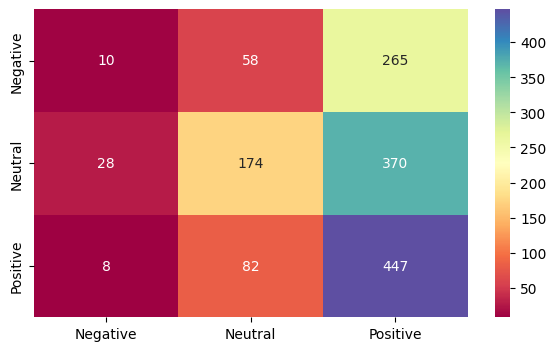

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.22      0.03      0.05       333
     Neutral       0.55      0.30      0.39       572
    Positive       0.41      0.83      0.55       537

    accuracy                           0.44      1442
   macro avg       0.39      0.39      0.33      1442
weighted avg       0.42      0.44      0.37      1442



In [ ]:
# Compute the confusion matrix
visualizeConfusionMatrix(y_test, bert_pred)

# Compute the classification report
class_report = classification_report(y_test, predictions, target_names=['Negative', 'Neutral', 'Positive'])
print(f"Classification Report: \n {class_report}")


In [ ]:
bert_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch in test_dataloader:
        outputs = bert_model(batch[0], attention_mask=batch[1], labels=batch[2])
        loss = outputs.loss
        total_test_loss += loss.item()

average_test_loss = total_test_loss / len(test_dataloader)
print("Average Test Loss:", average_test_loss)

Average Test Loss: 1.0848490518072378


- Based on the results above, the BERT model performed the least as it overfits on the test dataset as evident on the training and test loss.

#### Improving the Models
- Our goal here is to improve the random forest, gradient boosting, and light gradient boosting models. One way to improve the models would be to balance the data using SMOTE, and training the 3 models on the balanced dataset.
- However, `SMOTE` cannot be applied directly on text reviews.
- Thus, we would first implement the DistilBERT model to extract convert features in form of embeddings from the users comments. Then, we would re-implement the 3 models on the balanced embeddings dataset.

In [ ]:
# select the features and target
X = df.Tweet
y = df.label

In [ ]:
from imblearn.over_sampling import SMOTE
from transformers import DistilBertTokenizer, DistilBertModel

# Load the DistilBERT tokenizer and model
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_emb_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Preprocess the data and convert text to BERT embeddings
def getBERTEmbeddings(text, tokenizer, model):
    inputs = tokenizer(text.tolist(), padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = bert_emb_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Use mean pooling to get fixed-size representations
    return embeddings

bert_embeddings = getBERTEmbeddings(X, bert_tokenizer, bert_emb_model)


In [ ]:
# load the clean data
path = "/content/drive/MyDrive/Files/Olaitan/data/clean_data/df_clean.csv"
clean_df = pd.read_csv(path)

clean_df.shape

(9613, 2)

In [ ]:
clean_df.dropna(inplace = True)

In [ ]:
clean_df.shape

(9608, 2)

In [ ]:
# load the BERT embeddings
bert_embeddings = np.load("/content/drive/MyDrive/Files/Olaitan/data/BERT_embeddings/bert_embeddings.npy")

In [ ]:
bert_embeddings.shape

(9608, 768)

In [ ]:
X_real = bert_embeddings
y_real = clean_df.label

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_real, y_real)

# Split the data into train and test sets
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)



train accuracy : 0.960
              precision    recall  f1-score   support

    Negative       0.69      0.72      0.71       755
     Neutral       0.62      0.67      0.64       738
    Positive       0.65      0.57      0.60       793

    accuracy                           0.65      2286
   macro avg       0.65      0.65      0.65      2286
weighted avg       0.65      0.65      0.65      2286



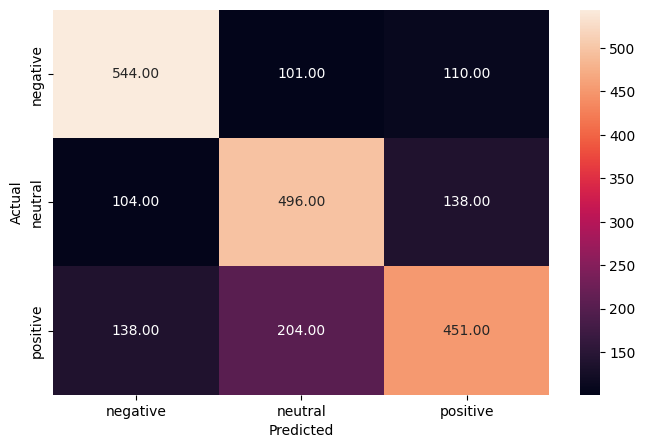

In [ ]:
# train the Light Gradient Boosting Model
gb_sm = lgb.LGBMClassifier(max_depth=5, random_state = 0, verbose = -1)

gb_sm = train_and_evaluate(gb_sm, X_train_sm, y_train_sm, X_test_sm, y_test_sm)

train accuracy : 0.999
              precision    recall  f1-score   support

    Negative       0.74      0.75      0.74       755
     Neutral       0.58      0.69      0.63       738
    Positive       0.64      0.52      0.57       793

    accuracy                           0.65      2286
   macro avg       0.65      0.65      0.65      2286
weighted avg       0.65      0.65      0.65      2286



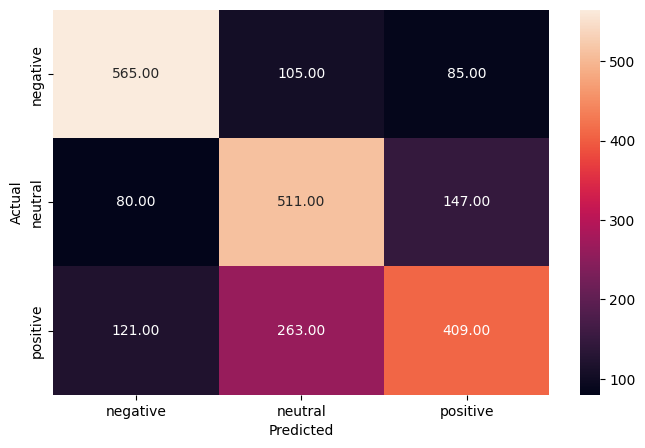

In [ ]:
# train the random forest model
from sklearn.ensemble import RandomForestClassifier
rf_sm = RandomForestClassifier(n_jobs=-1, random_state = 0)
rf_sm = train_and_evaluate(rf_sm, X_train_sm, y_train_sm, X_test_sm, y_test_sm)

train accuracy : 0.766
              precision    recall  f1-score   support

    Negative       0.63      0.66      0.64       755
     Neutral       0.58      0.66      0.62       738
    Positive       0.60      0.50      0.55       793

    accuracy                           0.60      2286
   macro avg       0.61      0.61      0.60      2286
weighted avg       0.61      0.60      0.60      2286



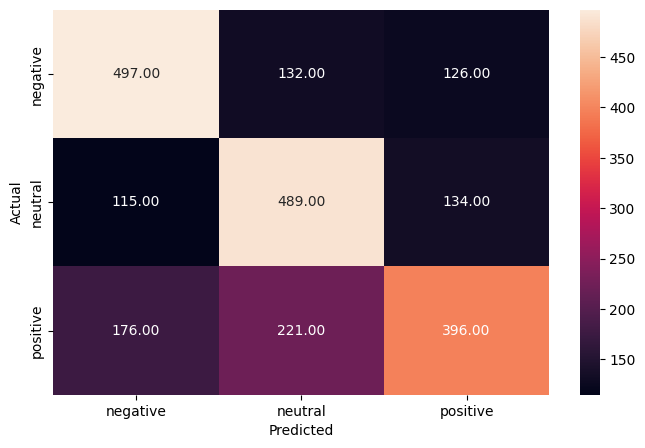

In [ ]:
# train the gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier

grb_sm = GradientBoostingClassifier()
grb_sm = train_and_evaluate(grb_sm, X_train_sm, y_train_sm, X_test_sm, y_test_sm)

- Based on the results above, the random forest model trained on the balanced embeddings obtained using the DistilBERT model performed the best among the 3 models.